In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [ ]:
# df = pd.read_csv('rnn_processed_data.csv')
# df.venue = pd.factorize(df.venue.to_list())[0] # turn strings to int

In [ ]:
# from sklearn.utils import shuffle
# df = shuffle(df, random_state=42).reset_index(drop=True)

In [ ]:
# X_train, y_train = df.iloc[:154521,:7], df.iloc[:154521,7:]
# X_test, y_test = df.iloc[154521:,:7].reset_index(drop=True) , df.iloc[154521:,7:].reset_index(drop=True)

In [3]:
X_train = pd.read_csv('rnn_x_train.csv')
X_test = pd.read_csv('rnn_x_test.csv')
X_train = X_train.drop(['id'], axis=1)
X_test = X_test.drop(['id'],axis=1)

numbers = set(X_train.venue.values) | set(X_test.venue.values)
d_numbers = {key:val for key, val in zip(numbers,range(len(numbers)))}

X_train.venue = X_train.venue.apply(lambda x: d_numbers[x])
X_test.venue = X_test.venue.apply(lambda x: d_numbers[x])


from sklearn.utils import shuffle
X_train = shuffle(X_train, random_state=42)
X_test = shuffle(X_test, random_state=42)

df_test = X_test.copy()
df_train = X_train.copy()

import gc
del X_train, X_test
gc.collect

X_train, y_train = df_train.iloc[:,:7], df_train.iloc[:,7:]
X_test, y_test = df_test.iloc[:,:7], df_test.iloc[:,7:]

In [4]:
# Define an input sequence.
encoder_inputs = keras.layers.Input(shape=(None, 1))

# Create a list of RNN Simple Memory Cells
encoder = keras.layers.SimpleRNN(units=512, return_state=True,
                                            activation='relu',
                                             dropout=0.2)

encoder_outputs_and_states = encoder(encoder_inputs)

# Keep the states
encoder_states = encoder_outputs_and_states[1:]

# Decoder will have zeros as an input
decoder_inputs = keras.layers.Input(shape=(None, 1))

decoder = keras.layers.SimpleRNN(units=512, return_sequences=True, return_state=True,
                                            activation='relu',
                                             dropout=0.2)

# Output state of encoder is input state of decoder
decoder_outputs_and_states = decoder(decoder_inputs, initial_state=encoder_states)

# The output of decoder
decoder_outputs = decoder_outputs_and_states[0]

# A dense layer to apply activation function
decoder_dense = keras.layers.Dense(1)

decoder_outputs = decoder_dense(decoder_outputs)

In [5]:
epocsh = 100
batch_size = 256

optimizer = keras.optimizers.RMSprop(lr=0.00001)

# We create and compile the model
model = keras.models.Model(inputs=[encoder_inputs, decoder_inputs], outputs=decoder_outputs)
model.compile(loss='mse', optimizer=optimizer, metrics=[keras.metrics.RootMeanSquaredError()])

In [6]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 1)]    0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None, 1)]    0                                            
__________________________________________________________________________________________________
simple_rnn (SimpleRNN)          [(None, 512), (None, 263168      input_1[0][0]                    
__________________________________________________________________________________________________
simple_rnn_1 (SimpleRNN)        [(None, None, 512),  263168      input_2[0][0]                    
                                                                 simple_rnn[0][1]      

In [ ]:
# Fit the model
model.fit([X_train.to_numpy()[..., np.newaxis], 
                        np.zeros((y_train.to_numpy().shape[0],y_train.to_numpy().shape[1],1))] ,
                        y_train.to_numpy()[..., np.newaxis],
                        epochs=epocsh)

In [7]:
from tensorflow.keras.models import load_model

# model.save('RNN_citation_prediction.h5')  # creates a HDF5 file 'my_model.h5'
# del model  # deletes the existing model

# returns a compiled model
# identical to the previous one
model = load_model('RNN_citation_prediction.h5')

In [8]:
score, acc = model.evaluate([X_test.to_numpy()[..., np.newaxis], 
                                  np.zeros((y_test.to_numpy().shape[0],y_test.to_numpy().shape[1],1))],
                           y_test.to_numpy()[..., np.newaxis])
print('MSE:', score)
print('RMSE:', acc)

1203/1203 [==============================] - 13s 11ms/step - loss: 206.1260 - root_mean_squared_error: 14.3571
MSE: 206.12600708007812
RMSE: 14.357081413269043


In [9]:
y_test_predicted = model.predict([X_test.to_numpy()[..., np.newaxis], 
                                  np.zeros((y_test.to_numpy().shape[0],y_test.to_numpy().shape[1],1))])

In [10]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_squared_log_error, explained_variance_score

print('R^2 for Optimized Parameters: {}'.format(r2_score(y_test.iloc[:,0], y_test_predicted[:,0])))
print('MSE for Optimized Parameters: {}'.format(mean_squared_error(y_test.iloc[:,0], y_test_predicted[:,0])))
print('MAE for Optimized Parameters: {}'.format(mean_absolute_error(y_test.iloc[:,0], y_test_predicted[:,0])))
print('EVS for Optimized Parameters: {}'.format(explained_variance_score(y_test.iloc[:,0], y_test_predicted[:,0])))


R^2 for Optimized Parameters: 0.9645207975353876
MSE for Optimized Parameters: 54.589356964915446
MAE for Optimized Parameters: 1.855434147198235
EVS for Optimized Parameters: 0.9664332637488303


In [11]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_squared_log_error, explained_variance_score

print('R^2 for Optimized Parameters: {}'.format(r2_score(y_test.iloc[:,1], y_test_predicted[:,1])))
print('MSE for Optimized Parameters: {}'.format(mean_squared_error(y_test.iloc[:,1], y_test_predicted[:,1])))
print('MAE for Optimized Parameters: {}'.format(mean_absolute_error(y_test.iloc[:,1], y_test_predicted[:,1])))
print('EVS for Optimized Parameters: {}'.format(explained_variance_score(y_test.iloc[:,1], y_test_predicted[:,1])))

R^2 for Optimized Parameters: 0.96001180467075
MSE for Optimized Parameters: 79.81557576701545
MAE for Optimized Parameters: 2.4146733835714755
EVS for Optimized Parameters: 0.9627198014239237


In [12]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_squared_log_error, explained_variance_score

print('R^2 for Optimized Parameters: {}'.format(r2_score(y_test.iloc[:,2], y_test_predicted[:,2])))
print('MSE for Optimized Parameters: {}'.format(mean_squared_error(y_test.iloc[:,2], y_test_predicted[:,2])))
print('MAE for Optimized Parameters: {}'.format(mean_absolute_error(y_test.iloc[:,2], y_test_predicted[:,2])))
print('EVS for Optimized Parameters: {}'.format(explained_variance_score(y_test.iloc[:,2], y_test_predicted[:,2])))


R^2 for Optimized Parameters: 0.9646808559273915
MSE for Optimized Parameters: 86.99947147172
MAE for Optimized Parameters: 2.553068081679861
EVS for Optimized Parameters: 0.966618424279008


In [13]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_squared_log_error, explained_variance_score

print('R^2 for Optimized Parameters: {}'.format(r2_score(y_test.iloc[:,3], y_test_predicted[:,3])))
print('MSE for Optimized Parameters: {}'.format(mean_squared_error(y_test.iloc[:,3], y_test_predicted[:,3])))
print('MAE for Optimized Parameters: {}'.format(mean_absolute_error(y_test.iloc[:,3], y_test_predicted[:,3])))
print('EVS for Optimized Parameters: {}'.format(explained_variance_score(y_test.iloc[:,3], y_test_predicted[:,3])))


R^2 for Optimized Parameters: 0.965753287512342
MSE for Optimized Parameters: 101.88229813690245
MAE for Optimized Parameters: 2.811616259172237
EVS for Optimized Parameters: 0.9674905278468278


In [14]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_squared_log_error, explained_variance_score

print('R^2 for Optimized Parameters: {}'.format(r2_score(y_test.iloc[:,4], y_test_predicted[:,4])))
print('MSE for Optimized Parameters: {}'.format(mean_squared_error(y_test.iloc[:,4], y_test_predicted[:,4])))
print('MAE for Optimized Parameters: {}'.format(mean_absolute_error(y_test.iloc[:,4], y_test_predicted[:,4])))
print('EVS for Optimized Parameters: {}'.format(explained_variance_score(y_test.iloc[:,4], y_test_predicted[:,4])))


R^2 for Optimized Parameters: 0.9627850867716502
MSE for Optimized Parameters: 131.46172899686877
MAE for Optimized Parameters: 3.0960412513279505
EVS for Optimized Parameters: 0.964218236235078


In [15]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_squared_log_error, explained_variance_score

print('R^2 for Optimized Parameters: {}'.format(r2_score(y_test.iloc[:,5], y_test_predicted[:,5])))
print('MSE for Optimized Parameters: {}'.format(mean_squared_error(y_test.iloc[:,5], y_test_predicted[:,5])))
print('MAE for Optimized Parameters: {}'.format(mean_absolute_error(y_test.iloc[:,5], y_test_predicted[:,5])))
print('EVS for Optimized Parameters: {}'.format(explained_variance_score(y_test.iloc[:,5], y_test_predicted[:,5])))


R^2 for Optimized Parameters: 0.9567763396966589
MSE for Optimized Parameters: 176.74217919447602
MAE for Optimized Parameters: 3.386279129355947
EVS for Optimized Parameters: 0.9581553643995321


In [16]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_squared_log_error, explained_variance_score

print('R^2 for Optimized Parameters: {}'.format(r2_score(y_test.iloc[:,6], y_test_predicted[:,6])))
print('MSE for Optimized Parameters: {}'.format(mean_squared_error(y_test.iloc[:,6], y_test_predicted[:,6])))
print('MAE for Optimized Parameters: {}'.format(mean_absolute_error(y_test.iloc[:,6], y_test_predicted[:,6])))
print('EVS for Optimized Parameters: {}'.format(explained_variance_score(y_test.iloc[:,6], y_test_predicted[:,6])))


R^2 for Optimized Parameters: 0.9486003263561178
MSE for Optimized Parameters: 239.7555866989972
MAE for Optimized Parameters: 3.7311061087874666
EVS for Optimized Parameters: 0.9499009864011759


In [17]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_squared_log_error, explained_variance_score

print('R^2 for Optimized Parameters: {}'.format(r2_score(y_test.iloc[:,7], y_test_predicted[:,7])))
print('MSE for Optimized Parameters: {}'.format(mean_squared_error(y_test.iloc[:,7], y_test_predicted[:,7])))
print('MAE for Optimized Parameters: {}'.format(mean_absolute_error(y_test.iloc[:,7], y_test_predicted[:,7])))
print('EVS for Optimized Parameters: {}'.format(explained_variance_score(y_test.iloc[:,7], y_test_predicted[:,7])))


R^2 for Optimized Parameters: 0.9415834046186989
MSE for Optimized Parameters: 308.29194853027343
MAE for Optimized Parameters: 4.1441445696522115
EVS for Optimized Parameters: 0.942851300412989


In [18]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_squared_log_error, explained_variance_score

print('R^2 for Optimized Parameters: {}'.format(r2_score(y_test.iloc[:,8], y_test_predicted[:,8])))
print('MSE for Optimized Parameters: {}'.format(mean_squared_error(y_test.iloc[:,8], y_test_predicted[:,8])))
print('MAE for Optimized Parameters: {}'.format(mean_absolute_error(y_test.iloc[:,8], y_test_predicted[:,8])))
print('EVS for Optimized Parameters: {}'.format(explained_variance_score(y_test.iloc[:,8], y_test_predicted[:,8])))


R^2 for Optimized Parameters: 0.9323154295238412
MSE for Optimized Parameters: 397.7143562930312
MAE for Optimized Parameters: 4.531845307911155
EVS for Optimized Parameters: 0.9334531692466186


In [19]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_squared_log_error, explained_variance_score

print('R^2 for Optimized Parameters: {}'.format(r2_score(y_test.iloc[:,9], y_test_predicted[:,9])))
print('MSE for Optimized Parameters: {}'.format(mean_squared_error(y_test.iloc[:,9], y_test_predicted[:,9])))
print('MAE for Optimized Parameters: {}'.format(mean_absolute_error(y_test.iloc[:,9], y_test_predicted[:,9])))
print('EVS for Optimized Parameters: {}'.format(explained_variance_score(y_test.iloc[:,9], y_test_predicted[:,9])))


R^2 for Optimized Parameters: 0.9243952365710133
MSE for Optimized Parameters: 484.0078330097824
MAE for Optimized Parameters: 4.867777226369774
EVS for Optimized Parameters: 0.925327626663324


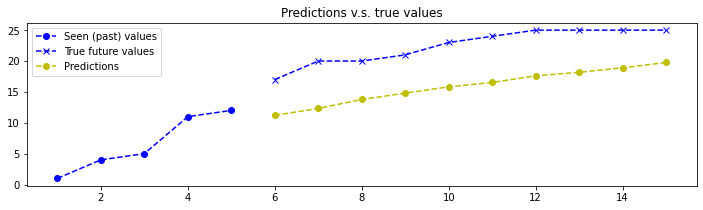

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 3))
plt.plot(range(1,6), X_test.iloc[5,2:], 'o--b', label="Seen (past) values")
plt.plot(range(6,16), y_test.iloc[5,:], 'x--b', label="True future values")
plt.plot(range(6,16), y_test_predicted[5], 'o--y', label="Predictions")
plt.legend(loc='best')
plt.title("Predictions v.s. true values")
plt.show()

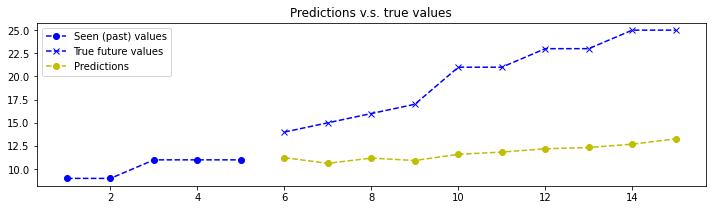

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 3))
plt.plot(range(1,6), X_test.iloc[22,2:], 'o--b', label="Seen (past) values")
plt.plot(range(6,16), y_test.iloc[22,:], 'x--b', label="True future values")
plt.plot(range(6,16), y_test_predicted[22], 'o--y', label="Predictions")
plt.legend(loc='best')
plt.title("Predictions v.s. true values")
plt.show()

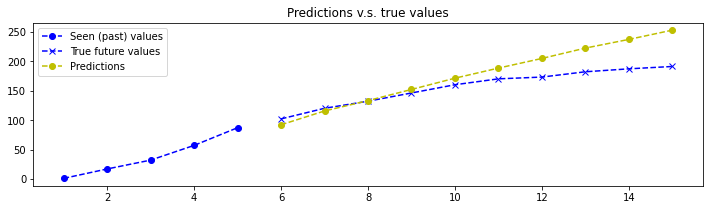

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 3))
plt.plot(range(1,6), X_test.iloc[2294,2:], 'o--b', label="Seen (past) values")
plt.plot(range(6,16), y_test.iloc[2294,:], 'x--b', label="True future values")
plt.plot(range(6,16), y_test_predicted[2294], 'o--y', label="Predictions")
plt.legend(loc='best')
plt.title("Predictions v.s. true values")
plt.show()

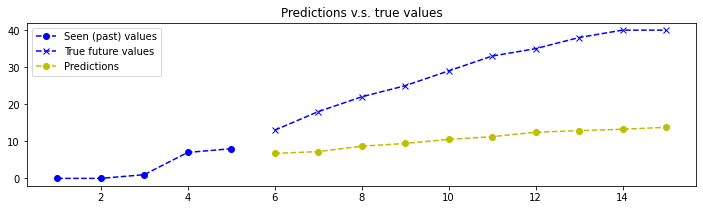

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 3))
plt.plot(range(1,6), X_test.iloc[4028,2:], 'o--b', label="Seen (past) values")
plt.plot(range(6,16), y_test.iloc[4028,:], 'x--b', label="True future values")
plt.plot(range(6,16), y_test_predicted[4028], 'o--y', label="Predictions")
plt.legend(loc='best')
plt.title("Predictions v.s. true values")
plt.show()

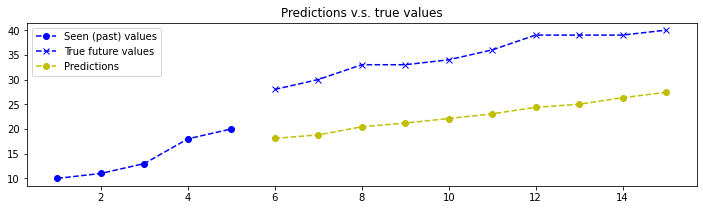

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 3))
plt.plot(range(1,6), X_test.iloc[6104,2:], 'o--b', label="Seen (past) values")
plt.plot(range(6,16), y_test.iloc[6104,:], 'x--b', label="True future values")
plt.plot(range(6,16), y_test_predicted[6104], 'o--y', label="Predictions")
plt.legend(loc='best')
plt.title("Predictions v.s. true values")
plt.show()

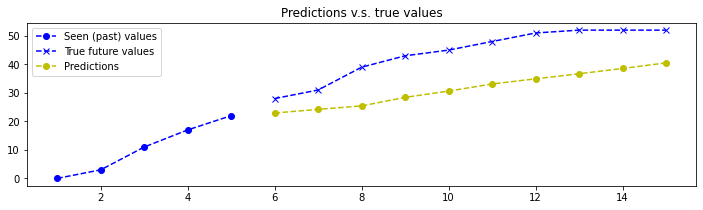

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 3))
plt.plot(range(1,6), X_test.iloc[38479,2:], 'o--b', label="Seen (past) values")
plt.plot(range(6,16),y_test.iloc[38479,:], 'x--b', label="True future values")
plt.plot(range(6,16), y_test_predicted[38479], 'o--y', label="Predictions")
plt.legend(loc='best')
plt.title("Predictions v.s. true values")
plt.show()